In [1]:
from my_functions import *

import numpy as np

import pandas as pd

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

from pprint import pprint

import pickle

import glob

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67

In [3]:
## Load my QSO catalog

filename = '/home/alberto/almacen/Source_cats/QSO_100000_v7_double/'
files = glob.glob(filename +'data*')
files.sort()
fi = []

for name in files:
    fi.append(pd.read_csv(name))

data_qso = pd.concat(fi, axis=0, ignore_index=True)

qso_flx = data_qso.to_numpy()[:, 1 : 60 + 1].T
qso_err = data_qso.to_numpy()[:, 60 + 1 : 120 + 1].T

EW_qso = data_qso['EW0'].to_numpy()
qso_zspec = data_qso['z'].to_numpy()

In [4]:
## Load SF catalog

filename = '/home/alberto/almacen/Source_cats/LAE_10deg_z2-4_v7_double/'
files = glob.glob(filename +'data*')
files.sort()
fi = []

for name in files:
    fi.append(pd.read_csv(name))

data = pd.concat(fi, axis=0, ignore_index=True)

sf_flx = data.to_numpy()[:, 1 : 60 + 1].T
sf_err = data.to_numpy()[:, 60 + 1 : 120 + 1].T

EW_sf = data['EW0'].to_numpy()
sf_zspec = data['z'].to_numpy()

In [5]:
pm_flx = np.hstack((qso_flx, sf_flx))
pm_err = np.hstack((qso_err, sf_err))
zspec = np.concatenate((qso_zspec, sf_zspec))
EW_lya = np.concatenate((EW_qso, EW_sf))

N_sf = sf_flx.shape[1]
N_qso = qso_flx.shape[1]

qso_dL = cosmo.luminosity_distance(qso_zspec).to(u.cm).value
sf_dL = cosmo.luminosity_distance(sf_zspec).to(u.cm).value

sf_L = data['L_lya'].to_numpy()
qso_L = data_qso['L_lya'].to_numpy()

sf_flambda = 10 ** sf_L / (4*np.pi * sf_dL **2)
qso_flambda = data_qso['F_line']

L_lya = np.concatenate((qso_L, sf_L))
fline = np.concatenate((qso_flambda, sf_flambda))

is_qso = np.concatenate((np.ones(N_qso), np.zeros(N_sf))).astype(bool)

N_sources = pm_flx.shape[1]

%xdel sf_flx
%xdel sf_err
%xdel qso_flx
%xdel qso_err
%xdel sf_zspec
%xdel qso_zspec
%xdel EW_sf
%xdel EW_qso
%xdel qso_dL
%xdel sf_L
%xdel qso_L
%xdel sf_flambda
%xdel qso_flambda
%xdel mock
%xdel data
%xdel data_qso

N_sources = pm_flx.shape[1]

mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

NameError: name 'mock' is not defined


/home/alberto/cosmos/LAEs/my_functions.py:24: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


In [6]:
# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, 20)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, pm_err, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    400, obs=True)
other_lines = identify_lines(line_other, pm_flx, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.12

%xdel cont_est_other
%xdel cont_err_other

In [7]:
mag_min = 17
mag_max = 25

nb_min = 3
nb_max = 20

# Used later!!
L_min = 40
L_max = 47

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
ew_cut = EW_lya > 20
mag_cut = (mag > mag_min) & (mag < mag_max)

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr
)
nice_lya = (nice_lya & z_cut & mag_cut)

/home/alberto/cosmos/LAEs/my_functions.py:499: RuntimeWarning: divide by zero encountered in double_scalars
  lya_L_err[src] = np.sum(pm_err[l - 7 : l - 1, src] ** -2) ** -0.5
/home/alberto/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alberto/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alberto/cosmos/LAEs/my_functions.py:508: RuntimeWarning: divide by zero encountered in double_scalars
  lya_R2_err[src] = np.sum(pm_err[l + 12 : l + 12 + 5, src] ** -2) ** -0.5


In [8]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

nice_lya = nice_lya & (L_lya > L_min) & (L_lya < L_max)

/home/alberto/cosmos/LAEs/my_functions.py:616: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_Arr = flambda / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:617: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_e = flambda_e / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:635: RuntimeWarning: divide by zero encountered in log10
  L_Arr = np.log10(flambda * 4*np.pi * dL ** 2)


In [9]:
nice_lya = nice_lya

N_nice_qso = count_true(nice_lya & is_qso)
N_nice_qso

21235

In [10]:
'''
The initial features are:
- The fluxes of the first 55 NBs
- The errors of the first 55 NBs
- 4 BB fluxes
- 4 BB errors
- The estimated L
- The estimated z
TOTAL = 120 features
(PCA to be applied below)
'''

# The data set is the nice_lya sample
NNdata = np.hstack(
    (
        pm_flx[:55, nice_lya].T,
        pm_flx[-4:, nice_lya].T,
        pm_err[:55, nice_lya].T / pm_flx[:55, nice_lya].T,
        pm_err[-4:, nice_lya].T / pm_flx[-4:, nice_lya].T,
        L_Arr[nice_lya].reshape(-1, 1),
        z_Arr[nice_lya].reshape(-1, 1)
    )
)

# Data augmentation by perturbing the fluxes
N_sources_NN = 100_000
# Select equal number of QSOs and SF
sample_sources = np.concatenate(
    (
        np.random.randint(0, N_nice_qso, int(N_sources_NN / 2)),
        np.random.randint(N_nice_qso, NNdata.shape[0], int(N_sources_NN / 2))
    )
)
randN_NB = np.random.normal(size=(N_sources_NN, 55))
randN_BB = np.random.normal(size=(N_sources_NN, 4))

# Select N_sources_NN samples
NNdata = NNdata[sample_sources]

# Shuffle data
shuffle_idx = np.random.permutation(np.arange(N_sources_NN))
NNdata = NNdata[shuffle_idx]

NNdata_mags = mag[nice_lya][sample_sources][shuffle_idx]
NNdata_L = L_Arr[nice_lya][sample_sources][shuffle_idx]
NNdata_L_input = L_lya[nice_lya][sample_sources][shuffle_idx]
NNdata_isqso = is_qso[nice_lya][sample_sources][shuffle_idx]

NNdata_L_input[np.isnan(NNdata_L_input)] = 0.

# Apply perturbation
# NNdata[:, :55] += NNdata[:, 55 + 4 : 59 + 55] * NNdata[:, :55] * randN_NB
# NNdata[:, 55 : 55 + 4] += NNdata[:, 59 + 55 : 59 + 55 + 4] * NNdata[:, 55 : 55 + 4] * randN_BB

# Take logs
NNdata[:, :55 + 4] = np.log10(NNdata[:, :55 + 4])

NNdata[np.isnan(NNdata)] = 99.

# The labels are is_qso
NNlabels = is_qso[nice_lya]
# And also augmentate
NNlabels = NNlabels[sample_sources]
# And shuffle
NNlabels = NNlabels[shuffle_idx]

# Rescale data
NNdata = MinMaxScaler().fit_transform(NNdata)

# Apply PCA
pca = PCA(n_components=0.95, svd_solver='full')

pca.fit(NNdata)
with open('MLmodels/QSO-SF_pca.sav', 'wb') as file:
    pickle.dump(pca, file)

NNdata = pca.transform(NNdata)

# Split dataset
NNdata_train, NNdata_test, NNlabels_train, NNlabels_test =\
    train_test_split(NNdata, NNlabels, test_size=0.2, shuffle=False)

N_train = len(NNlabels_train)
N_test = len(NNlabels_test)

/tmp/ipykernel_834037/889894247.py:56: RuntimeWarning: invalid value encountered in log10
  NNdata[:, :55 + 4] = np.log10(NNdata[:, :55 + 4])


In [11]:
# Create the parameter grid based on the results of random search 
param_dist = {
    'hidden_layer_sizes': [(20, 20), (30, 30), (50, 20), (60, 30)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'relu'],
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [10000],
    'n_iter_no_change': [20]
}
# Create a based model
nn = MLPRegressor()
# Instantiate the grid search model
nn_random = RandomizedSearchCV(
    estimator=nn, param_distributions=param_dist, n_iter=40,
    cv=5, verbose=99, random_state=42, n_jobs=-1, refit=True
)

# Fit the random search model
reg = nn_random.fit(NNdata_train, NNdata_L_input[:N_train])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 2/5; 3/40] START activation=logistic, alpha=1e-05, hidden_layer_sizes=(20, 20), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=sgd[CV 3/5; 1/40] START activation=logistic, alpha=0.001, hidden_layer_sizes=(60, 30), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=lbfgs

[CV 1/5; 2/40] START activation=relu, alpha=0.001, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=sgd
[CV 4/5; 1/40] START activation=logistic, alpha=0.001, hidden_layer_sizes=(60, 30), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=lbfgs
[CV 2/5; 2/40] START activation=relu, alpha=0.001, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=sgd
[CV 1/5; 3/40] START activation=logistic, alpha=1e-05, hidden_layer_sizes=(20, 20), learning_rate=adaptive, max_iter=10000, n_iter_no_change=20, solver=sgd
[CV 5/

In [ ]:
print(nn_random.best_params_)

{'solver': 'adam', 'n_iter_no_change': 20, 'max_iter': 10000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20, 20), 'alpha': 0.01, 'activation': 'logistic'}


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = MLPRegressor(random_state=42)
base_model.fit(NNdata_train, NNdata_L_input[:N_train])
base_accuracy = evaluate(base_model, NNdata_test, NNdata_L_input[N_train:])

Model Performance
Average Error: 0.9359 degrees.
Accuracy = 97.84%.


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
best_random = nn_random.best_estimator_
random_accuracy = evaluate(best_random, NNdata_test, NNdata_L_input[N_train:])
print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.2784 degrees.
Accuracy = 99.36%.
Improvement of 1.56%.


In [ ]:
L_lya_test = NNdata_L_input[N_train:]

In [ ]:
L_Arr_pred = reg.predict(NNdata_test)

In [ ]:
with open('MLmodels/NN_QSO-SF_regressor.sav', 'wb') as file:
    pickle.dump(reg, file)

In [ ]:
def plot_contours(maskkk, is_qso, title='', nb_c=-3):
    fig, ax = plt.subplots(figsize=(7, 6))

    mask = maskkk[is_qso]
    Z, x, y = np.histogram2d(
        L_lya_test[is_qso][mask], L_Arr_pred[is_qso][mask],
        bins=(np.linspace(41, 47, 30), np.linspace(41, 47, 30))
    )

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * (y[1:] + y[:-1])
    x_centers = 0.5 * (x[1:] + x[:-1])

    N_bins = 10000

    H_Arr = np.linspace(H_min, H_max, N_bins)[::-1]

    fact_up_Arr = np.zeros(N_bins)

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[mask]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1 sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2 sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 3 sigma

    ax.contour(
        x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
        colors='C0'
    )

    mask = ~is_qso & maskkk
    Z, x, y = np.histogram2d(
        L_lya_test[mask], L_Arr_pred[mask],
        bins=(np.linspace(41, 47, 30), np.linspace(41, 47, 30))
    )

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * (y[1:] + y[:-1])
    x_centers = 0.5 * (x[1:] + x[:-1])

    N_bins = 10000

    H_Arr = np.linspace(H_min , H_max , N_bins )[::-1]

    fact_up_Arr = np.zeros(N_bins)

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

    ax.contour(
        x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
        colors='C1'
    )

    x = np.linspace(40, 48, 100)
    ax.plot(x, x, linestyle='--', color='red', label='1:1')

    ax.set_ylabel('Retrieved $\log L$', fontsize=15)
    ax.set_xlabel('Real $\log L$', fontsize=15)

    ax.set_ylim((41, 47))
    ax.set_xlim((41, 47))

    if len(title) > 0:
        ax.set_title(title, fontsize=20)

    # Detec lim

    detec_lim = np.vstack(
        (
            pd.read_csv('csv/5sigma_depths_NB.csv', header=None),
            pd.read_csv('csv/5sigma_depths_BB.csv', header=None)
        )
    )[:, 1]

    flambda_lim = mag_to_flux(detec_lim[nb_c], w_central[nb_c]) * 3

    ew0_lim = 20 # A
    z = w_central[nb_c] / 1215.67 - 1
    Fline_lim = ew0_lim * flambda_lim * (1 + z)
    dL = cosmo.luminosity_distance(z).to(u.cm).value
    L_lim = np.log10(Fline_lim * 4*np.pi * dL**2)

    ax.axhline(L_lim, ls='--', color='green', label='L limit')

    ax.legend(fontsize=15)
    # plt.savefig(f'/home/alberto/Desktop/{title}')
    plt.show()

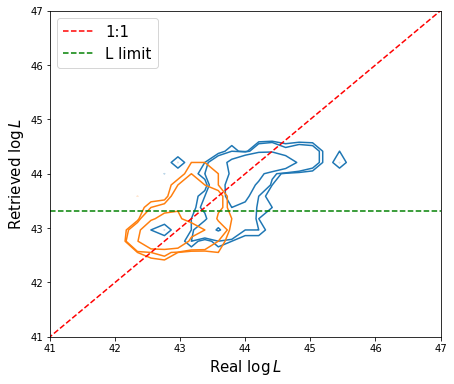

In [ ]:
plot_contours(L_Arr_pred.astype(bool), NNlabels_test)